# Treinamento (Desafio) #

Importando bibliotecas básicas:

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Função que retorna a porcentagem de dados nulos por coluna:

In [2]:
def get_missing_data(df):
    missing_data = (df.isnull().sum() / df.shape[0]) * 100
    return dict(missing_data)

Função que trata o problema dos dados nulos no dataframe:

In [3]:
def fill_missed_values(df):
    missing_data = get_missing_data(df)
    for miss in missing_data:
        if missing_data[miss] > 0:
            try:
                df[miss] = df[miss].fillna(df[miss].mean())
            except:
                df[miss] = df[miss].fillna('missed')
    return df

Função que remove linhas onde a informação de chuva (RainTomorrow) é nula:

In [4]:
def drop_rain_missed(df):
    idx = df[
        (df['RainToday'] == 'missed') |
        (df['RainTomorrow'] == 'missed')
    ].index
    return df.drop(idx)

Função que aplica enconding nos dados não numéricos:

In [5]:
def encoding_data(df):
    for column in df.columns:
        if type(df[column].iloc[2] == str):
            df[column] = le.fit_transform(df[column])
    return df

Função para mostrar as metricas com os desvios padrão:

In [6]:
def show_cv_metrics(str, cv_result):
    print(f'{str}: {cv_result[str].mean()} +/- {cv_result[str].std()}')

Importando o Dataset:

In [7]:
train_ds = pd.read_csv('input/train.csv')
test_ds = pd.read_csv('input/test.csv')

Fazendo Id como index dos dataframes:

In [8]:
train_ds.set_index('Id', inplace=True)
test_ds.set_index('Id', inplace=True)

Tratando dados nulos:

In [9]:
train_ds = fill_missed_values(train_ds)
test_ds = fill_missed_values(test_ds)

Removendo dados que não serão usados:

In [10]:
train_ds.drop(['Date', 'Location'], axis=1, inplace=True)
test_ds.drop(['Date', 'Location'], axis=1, inplace=True)

Preparando dados:

In [11]:
data = pd.concat([train_ds, test_ds])

data.head(3)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Id,,,,,,,,,,,,,,,,,,,,,
2,7.4,25.1,0.0,5.464482,7.621446,WNW,44.0,NNW,WSW,4.0,...,44.0,25.0,1010.6,1007.8,4.425827,4.501143,17.2,24.3,No,No
3,12.9,25.7,0.0,5.464482,7.621446,WSW,46.0,W,WSW,19.0,...,38.0,30.0,1007.6,1008.7,4.425827,2.000000,21.0,23.2,No,No
4,9.2,28.0,0.0,5.464482,7.621446,NE,24.0,SE,E,11.0,...,45.0,16.0,1017.6,1012.8,4.425827,4.501143,18.1,26.5,No,No


Checando de fato não há mais nenhum dado nulo no dataframe:

In [12]:
print(get_missing_data(data))

{'MinTemp': 0.0, 'MaxTemp': 0.0, 'Rainfall': 0.0, 'Evaporation': 0.0, 'Sunshine': 0.0, 'WindGustDir': 0.0, 'WindGustSpeed': 0.0, 'WindDir9am': 0.0, 'WindDir3pm': 0.0, 'WindSpeed9am': 0.0, 'WindSpeed3pm': 0.0, 'Humidity9am': 0.0, 'Humidity3pm': 0.0, 'Pressure9am': 0.0, 'Pressure3pm': 0.0, 'Cloud9am': 0.0, 'Cloud3pm': 0.0, 'Temp9am': 0.0, 'Temp3pm': 0.0, 'RainToday': 0.0, 'RainTomorrow': 0.0}


Separando dados do teste (submissão) e dados para treino e validação:

In [13]:
test = data.loc[test_ds.index]
test.drop('RainTomorrow', axis=1, inplace=True)

data = data.loc[train_ds.index]

Importando biblioteca para aplicar label encoding:

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [15]:
data_le = data
data_le.shape[0]

113754

Removendo linhas do dataframe com informações de chuva (Yes/No) são nulos:

In [16]:
data_le = drop_rain_missed(data_le)
data_le.shape[0]

112608

Aplicando enconding:

In [17]:
data_le = encoding_data(data_le)

Definindo Feature e Target:

In [18]:
X = data_le.drop('RainTomorrow', axis=1)
y = data_le['RainTomorrow']

Aplicando StratifiedKFold e definindo modelo xgboost:

In [19]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

folds = 3

kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1234)

model = xgb.XGBClassifier(objective='binary:logistic')

Definindo os valores de X para valores entre 0 e 1:

In [20]:
from sklearn.preprocessing import MinMaxScaler

np.random.seed(1234)

scaler = MinMaxScaler()

X[X.columns] = scaler.fit_transform(X[X.columns])

Armazenando as features em uma variavel para facilitar o entendimento posteriormente:

In [21]:
feature_list = X.columns

Validação cruzada:

In [22]:
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

s = ['recall', 'precision', 'f1_macro', 'accuracy', 'roc_auc']

cv_result = cross_validate(model, X, y, cv=kfold, scoring=s, verbose=0)
cv_result

[23:16:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'fit_time': array([3.72521448, 3.20349669, 3.57334805]),
 'score_time': array([0.10517621, 0.11440802, 0.10112786]),
 'test_recall': array([0.54428554, 0.55221728, 0.54313867]),
 'test_precision': array([0.74088009, 0.72982846, 0.72528883]),
 'test_f1_macro': array([0.7694444 , 0.76947537, 0.76501085]),
 'test_accuracy': array([0.85677749, 0.8554188 , 0.85310102]),
 'test_roc_auc': array([0.88546519, 0.88321993, 0.883435  ])}

Exibindo metricas e seus devidos desvios padrão:

In [23]:
show_cv_metrics('test_recall', cv_result)
show_cv_metrics('test_precision', cv_result)
show_cv_metrics('test_f1_macro', cv_result)
show_cv_metrics('test_accuracy', cv_result)
show_cv_metrics('test_roc_auc', cv_result)

test_recall: 0.5465471642563559 +/- 0.004036624234927131
test_precision: 0.731999128653206 +/- 0.006547553687299624
test_f1_macro: 0.767976870545338 +/- 0.0020973329813110102
test_accuracy: 0.855099104859335 +/- 0.0015178409562280597
test_roc_auc: 0.8840400409310131 +/- 0.0010115531781445448


Exibindo metricas como dataframe:

In [24]:
cv_result_df = pd.DataFrame(cv_result)
cv_result_df = cv_result_df.iloc[:,2:]
cv_result_df

,test_recall,test_precision,test_f1_macro,test_accuracy,test_roc_auc
0,0.544286,0.740880,0.769444,0.856777,0.885465
1,0.552217,0.729828,0.769475,0.855419,0.883220
2,0.543139,0.725289,0.765011,0.853101,0.883435


Plotando valores metricas por fold em um grafico de barras:

<AxesSubplot:>

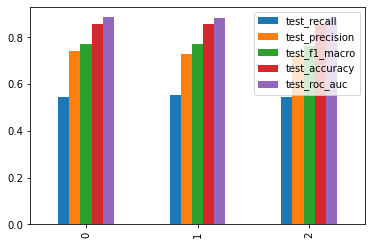

In [25]:
cv_result_df.plot(kind='bar')

Grade de aramentros para serem ajustados:

In [26]:
from scipy.stats import uniform
from scipy.stats import randint

param_grid = {
    'max_depth':randint(3,7),
    'learning_rate':uniform(0.01,0.05),
    'gamma':uniform(0,5),
    'reg_lambda':uniform(0,10),
    'scale_pos_weight':uniform(1,5),
    'subsamples':uniform(0.6,1.0),
    'colsample_bytree':uniform(0.5,1.0)
}

Aplicando RandomizedSearchCV:

In [27]:
from sklearn.model_selection import RandomizedSearchCV

moedel = xgb.XGBClassifier(objective='binary:logistic')

grid_cv = RandomizedSearchCV(model, param_grid, n_iter=500, cv=folds, scoring='roc_auc', n_jobs=-1, random_state=1234)

_ = grid_cv.fit(X,y)

[23:38:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "subsamples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:38:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Melhor roc_auc:

In [28]:
grid_cv.best_score_

0.866020828335292

Melhores parametros:

In [29]:
grid_cv.best_params_

{'colsample_bytree': 0.8189891657545427,
 'gamma': 4.555193365587465,
 'learning_rate': 0.05381445970936389,
 'max_depth': 6,
 'reg_lambda': 2.445561377953107,
 'scale_pos_weight': 1.3191841965244369,
 'subsamples': 1.0267541951920882}

Aplicando alguns ajustes em test (pré-processamento):

In [30]:
test = encoding_data(test)

test[feature_list] = scaler.transform(test[feature_list])
test.head(3)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
Id,,,,,,,,,,,,,,,,,,,,
1,0.515464,0.482,0.009554,0.164179,0.531034,0.8125,0.318182,0.8125,0.8750,0.279070,0.325581,0.72,0.217822,0.316574,0.324627,0.9,0.5,0.472477,0.475806,0.0
5,0.621134,0.672,0.015924,0.164179,0.531034,0.8125,0.287879,0.0625,0.4375,0.093023,0.279070,0.83,0.326733,0.374302,0.304104,0.8,0.9,0.495413,0.635081,0.0
7,0.538660,0.526,0.000000,0.164179,0.531034,0.8125,0.363636,0.7500,0.8125,0.279070,0.325581,0.49,0.188119,0.351955,0.345149,0.1,0.5,0.502294,0.532258,0.0


Treinamento:

In [31]:
final_model = xgb.XGBClassifier(
    **grid_cv.best_params_,
    objective='binary:logistic'
)

final_model.fit(X, y)

[23:38:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "subsamples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:38:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8189891657545427,
              enable_categorical=False, gamma=4.555193365587465, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05381445970936389, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=2.445561377953107,
              scale_pos_weight=1.3191841965244369, subsample=1,
              subsamples=1.0267541951920882, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [32]:
pred = final_model.predict(test)

Submissão:

In [33]:
submission = pd.DataFrame({
    'Id': test.index,
    'RainTomorrow': pred
})

submission['RainTomorrow'] = submission['RainTomorrow'].astype('int')

submission.to_csv('submission.csv', index=False)